# Cyclic peptides

In [2]:
import pandas as pd
df_all= pd.read_csv('data/CycPeptMPDB/all.csv')
df_train = pd.read_csv('data/CycPeptMPDB/train.csv')
df_test = pd.read_csv('data/CycPeptMPDB/test.csv')

pd.set_option('display.max_colwidth', None)

# display(df_all.head()['helm'])

y_train = df_train.score.values
y_test = df_test.score.values
y_all = df_all.score.values

## Feature processing

### Fingerprints (fps)

In [3]:
import warnings
import numpy as np
from rdkit import Chem, rdBase, DataStructs
from rdkit.Chem import AllChem
from typing import List

rdBase.DisableLog('rdApp.error')
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

def fingerprints_from_smiles(smiles: List, size=2048):
    """
        Create ECFP fingerprints of smiles, with validity check
    """
    fps = []
    valid_mask = []
    for i, smile in enumerate(smiles):
        mol = Chem.MolFromSmiles(smile)
        valid_mask.append(int(mol is not None))
        fp = fingerprints_from_mol(mol, size=size) if mol else np.zeros((1, size))
        fps.append(fp)

    fps = np.concatenate(fps, axis=0)
    return fps, valid_mask


def fingerprints_from_mol(molecule, radius=3, size=2048, hashed=False):
    """
        Create ECFP fingerprint of a molecule
    """
    if hashed:
        fp_bits = AllChem.GetHashedMorganFingerprint(molecule, radius, nBits=size)
    else:
        fp_bits = AllChem.GetMorganFingerprintAsBitVect(molecule, radius, nBits=size)
    fp_np = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp_bits, fp_np)
    return fp_np.reshape(1, -1)

In [118]:
# train = True
train = False
if train:
    X_all = fingerprints_from_smiles(df_all.smi)[0]
    X_train = fingerprints_from_smiles(df_train.smi)[0]
    X_test = fingerprints_from_smiles(df_test.smi)[0]

    np.save('data/CycPeptMPDB/X_all_fps.npy', X_all)
    np.save('data/CycPeptMPDB/X_train_fps.npy', X_train)
    np.save('data/CycPeptMPDB/X_test_fps.npy', X_test)
else:
    X_all = np.load('data/CycPeptMPDB/X_all_fps.npy')
    X_train = np.load('data/CycPeptMPDB/X_train_fps.npy')
    X_test = np.load('data/CycPeptMPDB/X_test_fps.npy')

X_all.shape, y_all.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7451, 2048), (7451,), (5960, 2048), (5960,), (1491, 2048), (1491,))

### BERT features

In [ ]:
from dataset.tokenizer import SmilesTokenizer, AATokenizer, BPETokenizer
from model.bert import BERT
from utils.utils import parse_config, load_model
import torch

def load_bert_model(ckpt, config, device='cuda', model_type='smi_bert'):
    if model_type == 'smi_bert':
        tokenizer = SmilesTokenizer(max_len=config.data.max_len)
    elif model_type == 'aa_bert':
        tokenizer = AATokenizer(max_len=config.data.max_len)
    elif config.data.type == 'bpe':
        tokenizer = BPETokenizer(bpe_path=config.data.bpe_path, max_len=config.data.max_len)
    else:
        raise ValueError(f'Invalid model_type: {model_type}')

    model = BERT(tokenizer, **config.model)
    model = load_model(model, ckpt, device)
    model.eval()
    return model, device

def get_bert_embd(encoder, inputs, device='cuda',):
    with torch.no_grad():
        tokens = encoder.tokenize_inputs(inputs).to(device)
        batch_lens = (tokens != encoder.tokenizer.pad_token_id).sum(1)
        embd = encoder.embed(tokens)
        reps = []
        for i, tokens_len in enumerate(batch_lens):
            reps.append(embd[i, 1 : tokens_len - 1].mean(0))
    return torch.stack(reps)

def encode_with_bert(list, model, device='cuda', batch_size=128):
    reps = []
    for i in range(0, len(list), batch_size):
        reps.append(get_bert_embd(model, list[i : i + batch_size], device=device))
    reps = torch.cat(reps).cpu().numpy()
    # logger.info(f"list shape: {list.shape}, reps shape: {reps.shape}")
    return reps

#### SMILES BERT

In [ ]:
# train = True
train = False
if train:
    ckpt='results/train_smi_bert/model_2_1.966.pt'  # 0.555	0.809	0.339	0.705	0.588
    config_file='configs/train_smi_bert_test.yaml'
    config = parse_config(config_file)
    model, device = load_bert_model(ckpt=ckpt, config=config)

    X_all = encode_with_bert(df_all.smi, model)
    X_train = encode_with_bert(df_train.smi, model)
    X_test = encode_with_bert(df_test.smi, model)

    np.save('data/CycPeptMPDB/X_all_smi_bert.npy', X_all)
    np.save('data/CycPeptMPDB/X_train_smi_bert.npy', X_train)
    np.save('data/CycPeptMPDB/X_test_smi_bert.npy', X_test)
else:
    X_all = np.load('data/CycPeptMPDB/X_all_smi_bert.npy')
    X_train = np.load('data/CycPeptMPDB/X_train_smi_bert.npy')
    X_test = np.load('data/CycPeptMPDB/X_test_smi_bert.npy')

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5960, 512), (5960,), (1491, 512), (1491,))

### RDKit descriptors

In [2]:
import warnings
import numpy as np
from rdkit import Chem, rdBase, DataStructs
from rdkit.Chem import AllChem
from typing import List
from rdkit import rdBase, Chem
from rdkit.Chem import Descriptors, rdMolDescriptors

rdBase.DisableLog('rdApp.error')
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

def getMolDescriptors(mol, missingVal=0):
    """ calculate the full list of descriptors for a molecule """

    values, names = [], []
    for nm, fn in Descriptors._descList:
        try:
            val = fn(mol)
        except:
            val = missingVal
        values.append(val)
        names.append(nm)

    custom_descriptors = {'hydrogen-bond donors': rdMolDescriptors.CalcNumLipinskiHBD,
                          'hydrogen-bond acceptors': rdMolDescriptors.CalcNumLipinskiHBA,
                          'rotatable bonds': rdMolDescriptors.CalcNumRotatableBonds,}
    for nm, fn in custom_descriptors.items():
        try:
            val = fn(mol)
        except:
            val = missingVal
        values.append(val)
        names.append(nm)
    return values,names

# getMolDescriptors('CC(=O)SCCCC[C@H](N)C(O)=O')

#### Monomer descriptors

In [3]:
from utils.helm_utils import get_monomer_dicts

def get_smi_without_rgroups(monomer, monomers2smi_dict, monomers2r_groups_dict):
    smi = monomers2smi_dict[monomer]
    for r_group in monomers2r_groups_dict[monomer]: # replace r groups
        if monomers2r_groups_dict[monomer][r_group] == 'OH':
            smi = smi.replace(f'[*:_{r_group}]', 'O')
        elif monomers2r_groups_dict[monomer][r_group]  == 'H':
            smi = smi.replace(f'[*:_{r_group}]','')
        else:
            print(f"R group {r_group}, {monomers2r_groups_dict[monomer][r_group]}")
    return smi

In [13]:
def calculate_monomer_dps():
    monomers2smi_dict, monomers2r_groups_dict = get_monomer_dicts()
    monomers = list(monomers2smi_dict.keys())

    monomer_dps= []
    monomer_smis = []
    for monomer in monomers:
        smi = get_smi_without_rgroups(monomer, monomers2smi_dict, monomers2r_groups_dict)
        try:
            mol = Chem.MolFromSmiles(smi)
        except:
            print(f"convert {monomer} with smi {smi} to molecule failed!")
            mol = None
        dps, names = getMolDescriptors(mol)
        monomer_smis.append(smi)
        monomer_dps.append(dps)

    # min-max normalize of descriptors
    monomer_dps_np = np.array(monomer_dps)
    monomer_dps_np = (monomer_dps_np - np.min(monomer_dps_np, axis=0)) / (np.max(monomer_dps_np, axis=0) - np.min(monomer_dps_np, axis=0))

    df_monomer_dps = pd.DataFrame(monomer_dps_np, columns=names)
    df_monomer_dps['Symbol'] = monomers
    df_monomer_dps['smi'] = monomer_smis

    df_monomer_dps = df_monomer_dps.dropna(axis=1)
    df_monomer_dps.to_csv('data/pretrain/monomer_descriptors.csv', index=False)
    cols = df_monomer_dps.columns - ['Symbol', 'smi']
    monomers2dps = dict(zip(monomers, df_monomer_dps[cols].values))
    return monomers2dps

In [14]:
def load_monomer_dps():
    df_monomer_dps = pd.read_csv('data/pretrain/monomer_descriptors.csv')
    cols = [col for col in df_monomer_dps.columns if col not in ['Symbol', 'smi']]
    monomers2dps = dict(zip(monomers, df_monomer_dps[cols].values))
    return monomers2dps

In [34]:
from utils.helm_utils import get_monomer_dicts

def get_monomer_dps_from_helm(helm, monomers2dps, return_sum=True):
    
    polymers = helm.split('$')[0].split(',PEPTIDE')
    monomers = polymers[0].split('{')[1].split('}')[0].replace('[', '').replace(']', '').split('.')
    if len(polymers) > 1 and polymers[1] != '':
        print(f"{len(polymers)} polymers in helm!")
        for i in range(1, len(polymers)):
            print(f"polymer {i+1}, {polymers[i]}")
            monomer_next = polymers[i].split('{')[1].split('}')[0].replace('[', '').replace(']', '').split('.')
            monomers.extend(monomer_next)
    monomer_dps = np.array([monomers2dps[monomer] for monomer in monomers])
    if return_sum:
        monomer_dps = monomer_dps.sum(axis=0)
    return monomer_dps

def get_all_monomer_dps(helms, return_sum=False):
    monomers2dps = load_monomer_dps()
    all_monomer_dps = [get_monomer_dps_from_helm(helm, monomers2dps, return_sum=return_sum) for helm in helms]
    
    if return_sum: 
        return np.array(all_monomer_dps) 
    else: 
        # pad to same length with 0 padding
        max_len = max([len(monomer_dps) for monomer_dps in all_monomer_dps])
        all_monomer_dps = [np.pad(monomer_dps, ((0, max_len - len(monomer_dps)), (0, 0)), 'constant', constant_values=0) for monomer_dps in all_monomer_dps]
        
        # convert to 3d numpy array
        all_monomer_dps_np = np.empty((len(all_monomer_dps), all_monomer_dps[0].shape[0], all_monomer_dps[0].shape[1]))
        for i in range(len(all_monomer_dps)):
            all_monomer_dps_np[i] = all_monomer_dps[i]
        return all_monomer_dps_np

In [36]:
import numpy as np

# train = True
train = False
if train:
    
    X_all = get_all_monomer_dps(df_all.helm)
    X_train = get_all_monomer_dps(df_train.helm)
    X_test = get_all_monomer_dps(df_test.helm)

    np.save('data/CycPeptMPDB/X_all_monomer_dps.npy', X_all)
    np.save('data/CycPeptMPDB/X_train_monomer_dps.npy', X_train)
    np.save('data/CycPeptMPDB/X_test_monomer_dps.npy', X_test)
else:
    X_all = np.load('data/CycPeptMPDB/X_all_monomer_dps.npy')
    X_train = np.load('data/CycPeptMPDB/X_train_monomer_dps.npy')
    X_test = np.load('data/CycPeptMPDB/X_test_monomer_dps.npy')

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5960, 15, 189), (5960,), (1491, 15, 189), (1491,))

#### Peptide descriptors

In [38]:
def get_pep_dps_from_smi(smi):
    try:
        mol = Chem.MolFromSmiles(smi)
    except:
        print(f"convert smi {smi} to molecule failed!")
        mol = None
    
    dps, _ = getMolDescriptors(mol)
    return np.array(dps)

def get_pep_dps(smi_list):
    return np.array([get_pep_dps_from_smi(smi) for smi in smi_list])

In [55]:
import numpy as np

train = True
# train = False
if train:
    
    X_all = get_pep_dps(df_all.smi)
    X_train = get_pep_dps(df_train.smi)
    X_test = get_pep_dps(df_test.smi)

    np.save('data/CycPeptMPDB/X_all_pep_dps.npy', X_all)
    np.save('data/CycPeptMPDB/X_train_pep_dps.npy', X_train)
    np.save('data/CycPeptMPDB/X_test_pep_dps.npy', X_test)
else:
    X_all = np.load('data/CycPeptMPDB/X_all_pep_dps.npy')
    X_train = np.load('data/CycPeptMPDB/X_train_pep_dps.npy')
    X_test = np.load('data/CycPeptMPDB/X_test_pep_dps.npy')

X_all.shape, y_all.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7451, 211), (7451,), (5960, 211), (5960,), (1491, 211), (1491,))

## Modeling

### Final features

In [8]:
# features = ['pep_dps', ]
# features = ['fps', ]
# features = ['monomer_dps', ]
# features = ['smi_bert', ]
# features = ['2dps', ]

# features = ['pep_dps', 'fps', ]
# features = ['pep_dps', 'monomer_dps', ]
# features = ['pep_dps', 'smi_bert', ]
# features = ['pep_dps', '2dps', ]

# features = ['fps', 'monomer_dps', ]
# features = ['fps', 'smi_bert', ]
# features = ['fps', '2dps', ] 

# features = ['monomer_dps', 'smi_bert', ]

# features = ['fps', '2dps', 'pep_dps', ]
# features = ['fps', 'monomer_dps', 'pep_dps', ]
# features = ['fps', 'monomer_dps', 'smi_bert', ]
features = ['fps', 'pep_dps', 'smi_bert', ]

X_all_features = []
X_train_features = []
X_test_features = []
for feat in features:
    try:
        X_all = np.load(f'data/CycPeptMPDB/X_all_{feat}.npy')
        X_train = np.load(f'data/CycPeptMPDB/X_train_{feat}.npy')
        X_test = np.load(f'data/CycPeptMPDB/X_test_{feat}.npy')

        X_all_features.append(X_all)
        X_train_features.append(X_train)
        X_test_features.append(X_test)
    except:
        raise ValueError(f'Feature {feat} not supported')

X_all = np.concatenate(X_all_features, axis=1)
X_train = np.concatenate(X_train_features, axis=1)
X_test = np.concatenate(X_test_features, axis=1)

X_all.shape, y_all.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7451, 2771), (7451,), (5960, 2771), (5960,), (1491, 2771), (1491,))

In [9]:
import matplotlib.pyplot as plt
from utils.utils import get_regresssion_metrics

def plot_scatter_y(y, y_hat, x_label='y', y_label='y_hat', save_path=None):
    plt.scatter(y, y_hat, alpha=0.1)
    get_regresssion_metrics(y, y_hat)
    mae = np.mean(np.abs(y - y_hat))
    print(f'MAE: {mae:.3f}, y mean: {np.mean(y):.3f}, y_hat mean: {np.mean(y_hat):.3f}')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if save_path:
        plt.savefig(save_path+f'_{mae:.3f}.pdf', dpi=300, bbox_inches='tight')
    plt.show()

### XGBoost regressor

MAE 	 MSE 	 R2 	 Spearman 	 Pearson
0.511	0.756	-0.218	0.756	0.625
MAE: 0.511, y mean: -5.876, y_hat mean: -5.883


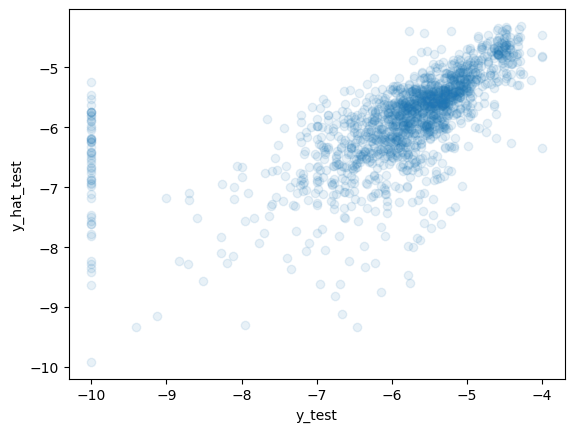

In [10]:
from xgboost import XGBRegressor

is_cv = False
is_save = False
save_path='data/CycPeptMPDB/fps_xgbr.model'

if is_cv:
    from numpy import absolute
    from sklearn.model_selection import RepeatedKFold, cross_val_score

    model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
    cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
    scores = cross_val_score(model, X_all, y_all, scoring='neg_mean_absolute_error', cv=cv, n_jobs=None)    # 16 min
    scores = absolute(scores)
    print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )
else:
    model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
    model.fit(X_train, y_train)
    if is_save:
        joblib.dump(model, save_path)
        model = joblib.load(save_path)
    y_hat = model.predict(X_test)
    plot_scatter_y(y_test, y_hat, x_label='y_test', y_label='y_hat_test', save_path=save_path)

### RF regressor

In [11]:
# from sklearn.ensemble import RandomForestRegressor
# import joblib

# is_cv = False
# is_save = False
# save_path='data/CycPeptMPDB/fps_rf.model'

# if is_cv:
#     from numpy import absolute
#     from sklearn.model_selection import RepeatedKFold, cross_val_score

#     model = RandomForestRegressor(max_depth=5, random_state=0)
#     cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
#     scores = cross_val_score(model, X_all, y_all, scoring='neg_mean_absolute_error', cv=cv, n_jobs=None)    # 16 min
#     scores = absolute(scores)
#     print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )
# else:
#     model = RandomForestRegressor(max_depth=5, random_state=0)
#     model.fit(X_train, y_train)
#     if is_save:
#         joblib.dump(model, save_path)
#         model = joblib.load(save_path)
#     y_hat = model.predict(X_test)
#     # model.save_model(save_path)
#     plot_scatter_y(y_test, y_hat, x_label='y_test', y_label='y_hat_test', save_path=save_path)